In [747]:
import pandas as pd
import numpy as np
import os
import itertools as it
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from time import time


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.tree import export_graphviz

In [748]:
#import all the files we need
reg_season_compact = pd.read_csv("RegularSeasonCompactResults.csv")
reg_season = pd.read_csv("RegularSeasonDetailedResults.csv")
seasons = pd.read_csv("Seasons.csv")
teams = pd.read_csv("Teams.csv")
tourney_results_compact = pd.read_csv("TourneyCompactResults.csv")
tourney_results = pd.read_csv("TourneyDetailedResults.csv")
seeds = pd.read_csv("TourneySeeds.csv")
slots = pd.read_csv("TourneySlots.csv")

In [823]:
reg_season.tail()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
76631,2017,132,1276,71,1458,56,N,0,27,48,...,15,6,8,14,18,10,15,4,3,13
76632,2017,132,1343,71,1463,59,N,0,25,52,...,20,13,19,14,20,12,7,4,5,13
76633,2017,132,1348,70,1433,63,N,0,24,54,...,14,17,22,23,24,8,5,4,1,16
76634,2017,132,1374,71,1153,56,N,0,26,52,...,24,14,18,17,22,7,7,7,1,13
76635,2017,132,1407,59,1402,53,N,0,21,60,...,17,7,8,9,27,10,17,1,7,18


In [749]:
#combine regular season and tourney result files
all_games = pd.concat([reg_season,tourney_results])

In [750]:
#setup elo data
mean_elo = 1500
elo_width = 400
k_factor = 64

In [751]:
#elo
df_concat = pd.concat((reg_season_compact, tourney_results_compact), ignore_index=True)
df_concat.drop(labels=[ 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)
df_concat.sort_values(by=['Season', 'Daynum'], inplace=True)

In [752]:
#label enocde the teams
le = LabelEncoder()
df_concat.Wteam = le.fit_transform(df_concat.Wteam)
df_concat.Lteam = le.fit_transform(df_concat.Lteam)

In [753]:
#setup functions
def update_elo(winner_elo, loser_elo):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def expected_result(elo_a, elo_b):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - mean_elo
    elos -= diff_from_mean/3
    return elos

In [754]:
df_concat['w_elo_before_game'] = 0
df_concat['w_elo_after_game'] = 0
df_concat['l_elo_before_game'] = 0
df_concat['l_elo_after_game'] = 0
elo_per_season = {}
n_teams = len(le.classes_)
current_elos = np.ones(shape=(n_teams)) * mean_elo

In [755]:
df_concat['w_elo_before_game'] = 0
df_concat['w_elo_after_game'] = 0
df_concat['l_elo_before_game'] = 0
df_concat['l_elo_after_game'] = 0
elo_per_season = {}
n_teams = len(le.classes_)
current_elos = np.ones(shape=(n_teams)) * mean_elo

In [756]:
#setup an epoch date field
df_concat['total_days'] = (df_concat.Season-1970)*365.25 + df_concat.Daynum

In [757]:
df_team_elos = pd.DataFrame(index=df_concat.total_days.unique(), 
                            columns=range(n_teams))
df_team_elos.iloc[0, :] = current_elos

In [758]:
#fire the photon cannons
current_season = df_concat.at[0, 'Season']
for row in df_concat.itertuples():
    if row.Season != current_season:
        # Check if we are starting a new season. 
        # Regress all ratings towards the mean
        current_elos = update_end_of_season(current_elos)
        # Write the beginning of new season ratings to a dict for later lookups.
        elo_per_season[row.Season] = current_elos.copy()
        current_season = row.Season
    idx = row.Index
    w_id = row.Wteam
    l_id = row.Lteam
    # Get current elos
    w_elo_before = current_elos[w_id]
    l_elo_before = current_elos[l_id]
    # Update on game results
    w_elo_after, l_elo_after = update_elo(w_elo_before, l_elo_before)
        
    # Save updated elos
    df_concat.at[idx, 'w_elo_before_game'] = w_elo_before
    df_concat.at[idx, 'l_elo_before_game'] = l_elo_before
    df_concat.at[idx, 'w_elo_after_game'] = w_elo_after
    df_concat.at[idx, 'l_elo_after_game'] = l_elo_after
    current_elos[w_id] = w_elo_after
    current_elos[l_id] = l_elo_after
    
    # Save elos to team DataFrame
    today = row.total_days
    df_team_elos.at[today, w_id] = w_elo_after
    df_team_elos.at[today, l_id] = l_elo_after

In [759]:
#bring the teams back to life
df_concat.Wteam = le.inverse_transform(df_concat.Wteam)
df_concat.Lteam = le.inverse_transform(df_concat.Lteam)

In [760]:
#split up the elo file for joining to the winners and losers tables below
elo_final = df_concat[['Season','Daynum','Wteam','Lteam','w_elo_before_game','l_elo_before_game']]
elo_winners = elo_final[['Season','Daynum','Wteam','w_elo_before_game','l_elo_before_game']]
elo_losers = elo_final[['Season','Daynum','Lteam','l_elo_before_game','w_elo_before_game']]

In [761]:
#split into DF for winners and losers
winners = all_games[['Season','Daynum','Wteam','Wfgm','Wfga','Wfgm3','Wfga3','Wor','Wdr','Wfta','Wast','Lfga','Lfgm','Lfga3','Lfgm3']]
losers = all_games[['Season','Daynum','Lteam','Lfgm','Lfga','Lfgm3','Lfga3','Lor','Ldr','Lfta','Last','Wfga','Wfgm','Wfga3','Wfgm3']]

In [762]:
winners = pd.merge(winners,elo_winners,how='left',on=['Season','Daynum','Wteam'])
losers = pd.merge(losers,elo_losers,how='left',on=['Season','Daynum','Lteam'])

In [763]:
#set columns for team and opponent
cols = ['Season','Daynum','Team','fgm','fga','fgm3','fga3','oreb','dreb','fta','ast','opp_fga','opp_fgm','opp_fga3','opp_fgm3','elo','opp_elo']
winners.columns = cols
losers.columns = cols

In [764]:
#add a column to indicate if the team was a winner or a loser
winners['team_type'] = 'winners'
losers['team_type'] = 'losers'

In [765]:
#union the DFs together so we have a row for each team and each game
df = pd.concat([winners,losers])
df = df.sort_values(['Season','Team','Daynum'], ascending=[1,1,1])

In [766]:
#add in running totals to calculate stats at points in the season
df['fgm_runn']= df.groupby(['Season','Team'])['fgm'].cumsum()
df['fga_runn']= df.groupby(['Season','Team'])['fga'].cumsum()
df['fgm3_runn']= df.groupby(['Season','Team'])['fgm3'].cumsum()
df['fga3_runn']= df.groupby(['Season','Team'])['fga3'].cumsum()
df['oreb_runn']= df.groupby(['Season','Team'])['oreb'].cumsum()
df['dreb_runn']= df.groupby(['Season','Team'])['dreb'].cumsum()
df['fta_runn']= df.groupby(['Season','Team'])['fta'].cumsum()
df['ast_runn']= df.groupby(['Season','Team'])['ast'].cumsum()
df['opp_fga_runn']= df.groupby(['Season','Team'])['opp_fga'].cumsum()
df['opp_fgm_runn']= df.groupby(['Season','Team'])['opp_fgm'].cumsum()
df['opp_fga3_runn']= df.groupby(['Season','Team'])['opp_fga3'].cumsum()
df['opp_fgm3_runn']= df.groupby(['Season','Team'])['opp_fgm3'].cumsum()

In [767]:
#shift the rows up by one row so that we get the stats leading into each game, not after each game
df['fgm_runn']= df.groupby(['Season','Team'])['fgm_runn'].transform(lambda x:x.shift(1))
df['fga_runn']= df.groupby(['Season','Team'])['fga_runn'].transform(lambda x:x.shift(1))
df['fgm3_runn']= df.groupby(['Season','Team'])['fgm3_runn'].transform(lambda x:x.shift(1))
df['fga3_runn']= df.groupby(['Season','Team'])['fga3_runn'].transform(lambda x:x.shift(1))
df['oreb_runn']= df.groupby(['Season','Team'])['oreb_runn'].transform(lambda x:x.shift(1))
df['dreb_runn']= df.groupby(['Season','Team'])['dreb_runn'].transform(lambda x:x.shift(1))
df['fta_runn']= df.groupby(['Season','Team'])['fta_runn'].transform(lambda x:x.shift(1))
df['ast_runn']= df.groupby(['Season','Team'])['ast_runn'].transform(lambda x:x.shift(1))
df['opp_fga_runn']= df.groupby(['Season','Team'])['opp_fga_runn'].transform(lambda x:x.shift(1))
df['opp_fgm_runn']= df.groupby(['Season','Team'])['opp_fgm_runn'].transform(lambda x:x.shift(1))
df['opp_fga3_runn']= df.groupby(['Season','Team'])['opp_fga3_runn'].transform(lambda x:x.shift(1))
df['opp_fgm3_runn']= df.groupby(['Season','Team'])['opp_fgm3_runn'].transform(lambda x:x.shift(1))

In [769]:
#=calculate the features we are going to use...

#3-pt FG %
df['fg3_pct'] = df['fgm3_runn'] / df['fga3_runn']

#3-pt FG ratio 
df['fg3_rate'] = df['fga3_runn'] / df['fga_runn']

#OREb % (off and def)
df['orr_rate'] = df['oreb_runn'] / (df['fga_runn'] - df['fgm_runn'])

#FTA/FGA
df['fta_rate'] = df['fta_runn'] / df['fga_runn']

#EFG Rate   (FGM + (0.5 x 3PTM)) / FGA
df['efg_rate'] = (df['fgm_runn'] + (.5 * df['fgm3_runn'])) / df['fga_runn']

#Opp EFG Rate 
df['opp_efg_rate'] = (df['opp_fgm_runn'] + (.5 * df['opp_fgm3_runn'])) / df['opp_fga_runn']

#days since last game
df['last_game']= df.groupby(['Season','Team'])['Daynum'].transform(lambda x:x.shift(1))
df['rest'] = df['Daynum'] - df['last_game']

In [770]:
#drop the columns which we aren't using for the model
df.drop(['fgm', 'fga', 'fgm3', 'fga3', 'oreb',
       'dreb', 'fta', 'ast', 'opp_fga', 'opp_fgm', 'opp_fga3', 'opp_fgm3',
       'fgm_runn', 'fga_runn', 'fgm3_runn', 'fga3_runn',
       'oreb_runn', 'dreb_runn', 'fta_runn', 'ast_runn', 'opp_fga_runn',
       'opp_fgm_runn', 'opp_fga3_runn', 'opp_fgm3_runn','last_game'],axis=1,inplace=True)

In [771]:
#create winners and losers columns
winners_final = df[df['team_type']=='winners']
winners_final.rename(columns={'Team':'Wteam'}, inplace=True)

losers_final = df[df['team_type']=='losers']
losers_final.rename(columns={'Team':'Lteam'}, inplace=True)

C:\Users\coreyjez\Anaconda3\lib\site-packages\pandas\core\frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [773]:
#build df to actually run prediction on 
#team a
#team a stats: rest, fg3_pct, fg3_rate, orr_rate, fta_rate, efg_rate, opp_efg_rate
#team b 
#team b stats: rest, fg3_pct, fg3_rate, orr_rate, fta_rate, efg_rate, opp_efg_rate
#team a wins? target

final = all_games[['Season','Daynum','Wteam','Lteam','Wscore','Lscore']]
final = pd.merge(final,winners_final,how='inner',on=['Season','Daynum','Wteam'])
final = pd.merge(final,losers_final,how='inner',on=['Season','Daynum','Lteam'])
final.columns

Index(['Season', 'Daynum', 'Wteam', 'Lteam', 'Wscore', 'Lscore', 'elo_x',
       'opp_elo_x', 'team_type_x', 'fg3_pct_x', 'fg3_rate_x', 'orr_rate_x',
       'fta_rate_x', 'efg_rate_x', 'opp_efg_rate_x', 'rest_x', 'elo_y',
       'opp_elo_y', 'team_type_y', 'fg3_pct_y', 'fg3_rate_y', 'orr_rate_y',
       'fta_rate_y', 'efg_rate_y', 'opp_efg_rate_y', 'rest_y'],
      dtype='object')

In [774]:
#drop Nan rows - these are first games of the season for each team
final = final.dropna(axis=0,how='any')

In [775]:
#rename columns for team X and Y
final.rename(columns={'Wteam':'team_x'}, inplace=True)
final.rename(columns={'Lteam':'team_y'}, inplace=True)
final.rename(columns={'Wscore':'team_x_score'}, inplace=True)
final.rename(columns={'Lscore':'team_y_score'}, inplace=True)

In [776]:
#reset DF to make the lower numbered team to be team X
final['team_x_is_min'] = (final.team_x < final.team_y).astype('int')

final_keep = final[final['team_x_is_min'] == 1]
final_change = final[final['team_x_is_min'] == 0]

In [777]:
#strip team x columns from final_change df
final_change_x = final_change[['Season','Daynum','team_x','team_x_score','elo_x','opp_elo_x','team_type_x','fg3_pct_x','fg3_rate_x','orr_rate_x',
                       'fta_rate_x','efg_rate_x','opp_efg_rate_x','rest_x','team_y']]

final_change_y = final_change[['Season','Daynum','team_y','team_y_score','elo_y','opp_elo_y','team_type_y','fg3_pct_y','fg3_rate_y','orr_rate_y',
                       'fta_rate_y','efg_rate_y','opp_efg_rate_y','rest_y','team_x']]

In [778]:
#new swapped column names 
cols_x = ['Season','Daynum','team_y','team_y_score','elo_y','opp_elo_y','team_type_y','fg3_pct_y','fg3_rate_y','orr_rate_y',
                       'fta_rate_y','efg_rate_y','opp_efg_rate_y','rest_y','team_x']

cols_y = ['Season','Daynum','team_x','team_x_score','elo_x','opp_elo_x','team_type_x','fg3_pct_x','fg3_rate_x','orr_rate_x',
                       'fta_rate_x','efg_rate_x','opp_efg_rate_x','rest_x','team_y']

In [779]:
#apply new column names
final_change_x.columns = cols_x
final_change_y.columns = cols_y

In [780]:
#join the data back together
final_swapped = pd.merge(final_change_x,final_change_y,how='inner',on=['Season','Daynum','team_x','team_y'])

In [781]:
#set target column on each DF 
final_keep['team_x_wins'] = 1 
final_swapped['team_x_wins'] = 0 

C:\Users\coreyjez\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [782]:
#rearrange the columns so they can be unioned together
final_swapped_cols = ['Season', 'Daynum', 'team_x', 'team_y', 'team_x_score', 'team_y_score','elo_x','opp_elo_x',
       'team_type_x', 'fg3_pct_x', 'fg3_rate_x', 'orr_rate_x', 'fta_rate_x',
       'efg_rate_x', 'opp_efg_rate_x', 'rest_x','elo_y','opp_elo_y','team_type_y', 'fg3_pct_y',
       'fg3_rate_y', 'orr_rate_y', 'fta_rate_y', 'efg_rate_y',
       'opp_efg_rate_y', 'rest_y', 'team_x_wins']

final_swapped = final_swapped[final_swapped_cols]

final_keep.drop('team_x_is_min',1,inplace=True)

C:\Users\coreyjez\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [783]:
#create the final table
final_final = pd.concat([final_keep,final_swapped])

In [784]:
#split into training and testing data to test on the 2016 NCAA tourney
train1 = final_final[final_final['Season']<2016]
train2 = final_final[(final_final['Season'] == 2016) & (final_final['Daynum']<134)]
train = pd.concat([train1,train2])
test = final_final[(final_final['Season'] == 2016) & (final_final['Daynum']>=134)]

In [785]:
#setup X and Y

X_train = train[['elo_x','fg3_pct_x', 'fg3_rate_x', 'orr_rate_x', 'fta_rate_x', 'efg_rate_x', 'opp_efg_rate_x',
       'elo_y','fg3_pct_y', 'fg3_rate_y',
       'orr_rate_y', 'fta_rate_y', 'efg_rate_y','opp_efg_rate_y',]]

y_train = train.team_x_wins

X_test = test[['elo_x','fg3_pct_x', 'fg3_rate_x', 'orr_rate_x', 'fta_rate_x', 'efg_rate_x','opp_efg_rate_x',
      'elo_y','fg3_pct_y', 'fg3_rate_y',
       'orr_rate_y', 'fta_rate_y', 'efg_rate_y','opp_efg_rate_y',]]

y_test = test.team_x_wins

In [786]:
#basic random forest
rf = RandomForestClassifier(n_jobs=-1,random_state=123)
cls = rf.fit(X_train,y_train)
preds = rf.predict(X_test)

In [787]:
proba_x = cls.predict_proba(X_test)[:,1]
#calculate the log_loss 
og_rf_err = log_loss(y_test,proba_x)
og_rf_err

0.63962673186386532

In [788]:
#lets tune some of the key parameters: n_estimators, max_features, max_depth, min_leaf_per_node
#first up is n_estimators
estimator_range = [20,500,20]

log_loss_scores = []

for estimator in estimator_range:
    tune = RandomForestClassifier(n_estimators=estimator,random_state=123,n_jobs=-1)
    cls_tune = tune.fit(X_train,y_train)
    preds = tune.predict(X_test)
    proba = cls_tune.predict_proba(X_test)[:,1]
    ll_error = log_loss(y_test,proba)
    log_loss_scores.append(ll_error)

KeyboardInterrupt: 

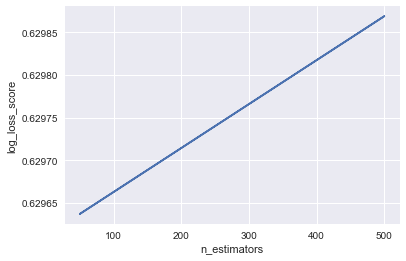

In [459]:
plt.plot(estimator_range,log_loss_scores)
plt.xlabel('n_estimators')
plt.ylabel('log_loss_score')

In [453]:
#it looks like 100 n_estimators is the best, but its basically flat so lets tune for the n features
# list of values to try for max_features
feature_range = [3,6,9,12,16]

# list to store the average RMSE for each value of max_features
log_loss_scores = []

for feature in feature_range:
    tune2 = RandomForestClassifier(n_estimators=100,max_features=feature,random_state=123,n_jobs=-1)
    cls_tune2 = tune2.fit(X_train,y_train)
    preds = tune2.predict(X_test)
    proba = cls_tune2.predict_proba(X_test)[:,1]
    ll_error = log_loss(y_test,proba)
    log_loss_scores.append(ll_error)

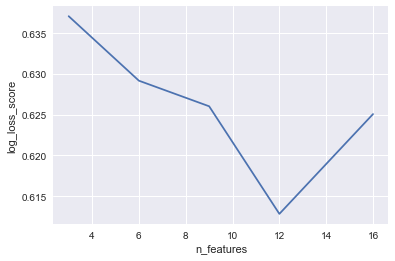

In [454]:
plt.plot(feature_range,log_loss_scores)
plt.xlabel('n_features')
plt.ylabel('log_loss_score')

In [456]:
#looks like 12 estimators is best, so finally lets tune for min_samples_split
#it looks like 100 n_estimators is the best, so lets tune for the n features
# list of values to try for max_features
min_samples = range(2,10,2)

# list to store the average log loss for each value of max_features
log_loss_scores = []

for samples in min_samples:
    tune2 = RandomForestClassifier(n_estimators=100,max_features=12,random_state=123,n_jobs=-1,min_samples_split=samples)
    cls_tune2 = tune2.fit(X_train,y_train)
    preds = tune2.predict(X_test)
    proba = cls_tune2.predict_proba(X_test)[:,1]
    ll_error = log_loss(y_test,proba)
    log_loss_scores.append(ll_error)

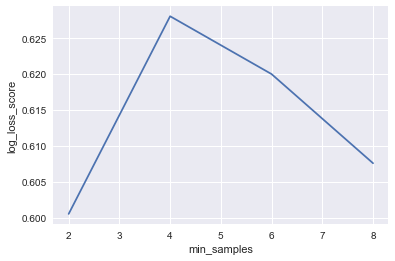

In [457]:
#best min samples is 2
plt.plot(min_samples,log_loss_scores)
plt.xlabel('min_samples')
plt.ylabel('log_loss_score')

In [789]:
#now we can run our best RF and get our baseline score and predictions
rf_best = RandomForestClassifier(n_jobs=-1,random_state=123,n_estimators=100,max_features=12,
                            min_samples_split=2)
cls = rf_best.fit(X_train,y_train)
preds = rf_best.predict(X_test)
proba_x = cls.predict_proba(X_test)[:,1]
best_rf_err = log_loss(y_test,proba_x)
print("original rf error:",og_rf_err)
print("best rf error:",best_rf_err)

original rf error: 0.639626731864
best rf error: 0.596895656258


In [790]:
#build final file to look at predictions
examine = test[['Season','Daynum','team_x', 'team_y', 'team_x_score', 'team_y_score']]
examine['pred'] = preds
examine['proba'] = proba_x
examine = pd.merge(examine,teams,how='inner',left_on='team_x',right_on='Team_Id')
examine = examine.drop('Team_Id',1)
examine.rename(columns={'Team_Name':'team_x_name'}, inplace=True)
examine = pd.merge(examine,teams,how='inner',left_on='team_y',right_on='Team_Id')
examine = examine.drop('Team_Id',1)
examine.rename(columns={'Team_Name':'team_y_name'}, inplace=True)
examine.to_csv("test_2016.csv")

C:\Users\coreyjez\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\coreyjez\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [801]:
#apply the bracket to our 2017 touranment ERMAGHERD ITS HAPPENING (insert Ron paul gif here)
sample = pd.read_csv("SampleSubmission.csv")

In [802]:
sample.drop('Pred',axis=1,inplace=True)
sample = sample['Id'].apply(lambda x: pd.Series(x.split('_')))

In [803]:
cols = ['Year','team_x','team_y']
sample.columns = cols
sample['team_x'] = pd.to_numeric(sample.team_x)
sample['team_y'] = pd.to_numeric(sample.team_y)

In [804]:
#join over stats 
data = df[df['Season']==2017]
data = data.dropna(how='any')
data.head()

,Season,Daynum,Team,elo,opp_elo,team_type,fg3_pct,fg3_rate,orr_rate,fta_rate,efg_rate,opp_efg_rate,rest
71833,2017,22,1101,1406,1238,losers,0.333333,0.326087,0.125000,0.630435,0.532609,0.391667,5.0
72009,2017,25,1101,1359,1798,losers,0.250000,0.297872,0.177778,0.500000,0.558511,0.443966,3.0
72273,2017,30,1101,1355,1555,losers,0.280000,0.331126,0.230769,0.437086,0.529801,0.426901,5.0
72337,2017,33,1101,1339,1276,winners,0.297297,0.371859,0.226415,0.381910,0.522613,0.438356,3.0
72844,2017,47,1101,1366,1264,losers,0.340909,0.353414,0.234375,0.409639,0.546185,0.455830,14.0


In [805]:
max_date = data.groupby(['Team'],sort=False,axis=0,)['Daynum'].max()

In [806]:
max_date = pd.DataFrame(max_date,index=None)
max_date.head()

,Daynum
Team,
1101,124
1102,129
1103,131
1104,131
1105,124


In [807]:
data = pd.merge(data,max_date,how='left',left_on='Team',right_index=True)

In [808]:
data = data[data['Daynum_x'] == data['Daynum_y']]

In [809]:
data = data.drop(['opp_elo','team_type','rest','Daynum_y'],axis=1)

In [810]:
sample.head()

,Year,team_x,team_y
0,2017,1112,1116
1,2017,1112,1124
2,2017,1112,1137
3,2017,1112,1139
4,2017,1112,1153


In [812]:
#populate team x values
df_final = pd.merge(sample,data,how='inner',left_on='team_x',right_on='Team')
df_final.head()

,Year,team_x,team_y,Season,Daynum_x,Team,elo,fg3_pct,fg3_rate,orr_rate,fta_rate,efg_rate,opp_efg_rate
0,2017,1112,1116,2017,131,1112,2008,0.398927,0.306637,0.35796,0.40757,0.53401,0.471118
1,2017,1112,1124,2017,131,1112,2008,0.398927,0.306637,0.35796,0.40757,0.53401,0.471118
2,2017,1112,1137,2017,131,1112,2008,0.398927,0.306637,0.35796,0.40757,0.53401,0.471118
3,2017,1112,1139,2017,131,1112,2008,0.398927,0.306637,0.35796,0.40757,0.53401,0.471118
4,2017,1112,1153,2017,131,1112,2008,0.398927,0.306637,0.35796,0.40757,0.53401,0.471118


In [813]:
df_final = df_final.drop(['Season','Daynum_x','Team'],axis=1)
df_final = df_final.rename(columns={
    'elo':'elo_x','fg3_pct':'fg3_pct_x','fg3_rate':'fg3_rate_x','orr_rate':'orr_rate_x',
    'fta_rate':'fta_rate_x','efg_rate':'efg_rate_x'
})

In [814]:
#populate team y values
df_final = pd.merge(df_final,data,how='inner',left_on='team_y',right_on='Team',suffixes=['','_y'])


In [815]:
df_final = df_final.drop(['Season','Daynum_x','Team'],axis=1)
df_final = df_final.rename(columns={
    'elo':'elo_y','fg3_pct':'fg3_pct_y','fg3_rate':'fg3_rate_y','orr_rate':'orr_rate_y',
    'fta_rate':'fta_rate_y','efg_rate':'efg_rate_y'
})

In [816]:
df_final.head()

,Year,team_x,team_y,elo_x,fg3_pct_x,fg3_rate_x,orr_rate_x,fta_rate_x,efg_rate_x,opp_efg_rate,elo_y,fg3_pct_y,fg3_rate_y,orr_rate_y,fta_rate_y,efg_rate_y,opp_efg_rate_y
0,2017,1112,1116,2008,0.398927,0.306637,0.357960,0.407570,0.534010,0.471118,1864,0.368243,0.297338,0.352007,0.388749,0.516826,0.480467
1,2017,1112,1124,2008,0.398927,0.306637,0.357960,0.407570,0.534010,0.471118,1862,0.351687,0.339771,0.426954,0.345806,0.526856,0.448642
2,2017,1116,1124,1864,0.368243,0.297338,0.352007,0.388749,0.516826,0.480467,1862,0.351687,0.339771,0.426954,0.345806,0.526856,0.448642
3,2017,1112,1137,2008,0.398927,0.306637,0.357960,0.407570,0.534010,0.471118,1649,0.378873,0.387766,0.298209,0.382305,0.555161,0.479630
4,2017,1116,1137,1864,0.368243,0.297338,0.352007,0.388749,0.516826,0.480467,1649,0.378873,0.387766,0.298209,0.382305,0.555161,0.479630


In [818]:
#split into training and testing data to test on the 2016 NCAA tourney
train_final = final_final

In [845]:
#setup X and Y

X_final_train = train_final[['elo_x','fg3_pct_x', 'fg3_rate_x', 'orr_rate_x', 'fta_rate_x', 'efg_rate_x', 'opp_efg_rate_x',
       'elo_y','fg3_pct_y', 'fg3_rate_y',
       'orr_rate_y', 'fta_rate_y', 'efg_rate_y','opp_efg_rate_y',]]

y_final_train = train_final.team_x_wins

X_final_test = df_final
X_final_test = X_final_test.drop(['Year','team_x','team_y'],axis=1)

In [846]:
X_final_train.head()

,elo_x,fg3_pct_x,fg3_rate_x,orr_rate_x,fta_rate_x,efg_rate_x,opp_efg_rate_x,elo_y,fg3_pct_y,fg3_rate_y,orr_rate_y,fta_rate_y,efg_rate_y,opp_efg_rate_y
7,1493,0.272727,0.239130,0.230769,0.369565,0.467391,0.508772,1461,0.272727,0.448980,0.548387,0.306122,0.428571,0.513158
14,1375,0.333333,0.375000,0.304348,0.125000,0.343750,0.535714,1472,0.315789,0.339286,0.437500,0.303571,0.482143,0.431818
15,1422,0.333333,0.346154,0.464286,0.519231,0.519231,0.525862,1467,0.266667,0.365854,0.409091,0.682927,0.512195,0.436364
16,1522,0.250000,0.145455,0.406250,0.709091,0.436364,0.512195,1565,0.454545,0.189655,0.300000,0.310345,0.525862,0.519231
17,1678,0.600000,0.362319,0.535714,0.188406,0.702899,0.365385,1533,0.538462,0.254902,0.272727,0.215686,0.637255,0.539683


In [847]:
X_final_test.head()

,elo_x,fg3_pct_x,fg3_rate_x,orr_rate_x,fta_rate_x,efg_rate_x,opp_efg_rate,elo_y,fg3_pct_y,fg3_rate_y,orr_rate_y,fta_rate_y,efg_rate_y,opp_efg_rate_y
0,2008,0.398927,0.306637,0.357960,0.407570,0.534010,0.471118,1864,0.368243,0.297338,0.352007,0.388749,0.516826,0.480467
1,2008,0.398927,0.306637,0.357960,0.407570,0.534010,0.471118,1862,0.351687,0.339771,0.426954,0.345806,0.526856,0.448642
2,1864,0.368243,0.297338,0.352007,0.388749,0.516826,0.480467,1862,0.351687,0.339771,0.426954,0.345806,0.526856,0.448642
3,2008,0.398927,0.306637,0.357960,0.407570,0.534010,0.471118,1649,0.378873,0.387766,0.298209,0.382305,0.555161,0.479630
4,1864,0.368243,0.297338,0.352007,0.388749,0.516826,0.480467,1649,0.378873,0.387766,0.298209,0.382305,0.555161,0.479630


In [850]:
#FIRE THE PHOTON CANNONS AGAIN!!!!
#predict the 2017 tournament

rf_final = RandomForestClassifier(n_jobs=-1,random_state=123,n_estimators=100,max_features=12,
                            min_samples_split=2)
cls = rf_final.fit(X_final_train,y_final_train)
preds_final = rf_best.predict(X_final_test)
proba_x_final = cls.predict_proba(X_final_test)[:,1]

In [851]:
proba_x_final.shape

(2278,)

In [853]:
#output results into readable spreadsheet
examine_final = sample[['Year','team_x', 'team_y']]
examine_final['pred'] = preds_final
examine_final['proba'] = proba_x_final
examine_final = pd.merge(examine_final,teams,how='inner',left_on='team_x',right_on='Team_Id')
examine_final = examine_final.drop('Team_Id',1)
examine_final.rename(columns={'Team_Name':'team_x_name'}, inplace=True)
examine_final = pd.merge(examine_final,teams,how='inner',left_on='team_y',right_on='Team_Id')
examine_final = examine_final.drop('Team_Id',1)
examine_final.rename(columns={'Team_Name':'team_y_name'}, inplace=True)
examine_final.head()
examine_final.to_csv("final_2017_new.csv")

In [854]:
examine_final['team_x'] = examine_final['team_x'].astype(str)
examine_final['team_y'] = examine_final['team_y'].astype(str)
examine_final['Year'] = examine_final['Year'].astype(str)

In [855]:
examine_final['Id'] = examine_final[['Year','team_x','team_y']].apply(lambda x: '_'.join(x),axis=1)

In [856]:
examine_final.head()

,Year,team_x,team_y,pred,proba,team_x_name,team_y_name,Id
0,2017,1112,1116,1,0.90,Arizona,Arkansas,2017_1112_1116
1,2017,1112,1124,1,0.71,Arizona,Baylor,2017_1112_1124
2,2017,1116,1124,0,0.43,Arkansas,Baylor,2017_1116_1124
3,2017,1112,1137,0,0.54,Arizona,Bucknell,2017_1112_1137
4,2017,1116,1137,0,0.47,Arkansas,Bucknell,2017_1116_1137


In [857]:
submit = examine_final[['proba','Id']]

In [858]:
cols = ['Id','proba']
submit = submit[cols]
submit = submit.rename(columns={'proba':'Pred'})
submit.head()

,Id,Pred
0,2017_1112_1116,0.90
1,2017_1112_1124,0.71
2,2017_1116_1124,0.43
3,2017_1112_1137,0.54
4,2017_1116_1137,0.47


In [859]:
submit.to_csv("kaggle_submission_new.csv")